# AlphaZero Tic Tac Toe


## Game rules

In [ ]:
import numpy as np

class TicTacToeGame:
    """
        rows: 3
        columns: 3
        winNumber: 3
    """

    def __init__(self):
        self.rows = 3
        self.columns = 3
        self.win = 3

    def get_init_board(self):
        b = np.zeros((self.rows, self.columns), dtype=np.int)
        return b

    def get_board_size(self):
        return (self.rows, self.columns)

    def get_action_size(self):
        return self.rows * self.columns

    def get_next_state(self, board, player, action):
        b = np.copy(board)
        row, col = divmod(action, self.columns)
        b[row][col] = player
        return (b, -player)

    def has_legal_moves(self, board):
        for row in range(self.rows):
            for col in range(self.columns):
                if board[row][col] == 0:
                    return True
        return False

    def get_valid_moves(self, board):
        valid_moves = [1 if board[i][j] == 0 else 0 for i in range(self.rows) for j in range(self.columns)]
        return valid_moves

    def is_win(self, board, player):
        # check rows
        for row in range(self.rows):
            if all(board[row][col] == player for col in range(self.columns)):
                return True
        # check columns
        for col in range(self.columns):
            if all(board[row][col] == player for row in range(self.rows)):
                return True
        # check diagonals
        if all(board[i][i] == player for i in range(self.rows)):
            return True
        if all(board[i][self.rows-i-1] == player for i in range(self.rows)):
            return True

        return False

    def get_reward_for_player(self, board, player):
        if self.is_win(board, player):
            return 1
        if self.is_win(board, -player):
            return -1
        if self.has_legal_moves(board):
            return None
        else : 
          return 0

    def get_canonical_board(self, board, player):
        return player * board



## Monte Carlo Tree Search

In [ ]:
import torch
import math
import numpy as np


def ucb_score(parent, child):
    """
    The score for an action that would transition between the parent and child.
    """
    prior_score = child.prior * math.sqrt(parent.visit_count) / (child.visit_count + 1)
    if child.visit_count > 0:
        # The value of the child is from the perspective of the opposing player
        value_score = -child.value()
    else:
        value_score = 0

    return value_score + prior_score


class Node:
    def __init__(self, prior, to_play):
        self.visit_count = 0
        self.to_play = to_play
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.state = None

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def select_action(self, temperature):
        """
        Select action according to the visit count distribution and the temperature.
        """
        visit_counts = np.array([child.visit_count for child in self.children.values()])
        actions = [action for action in self.children.keys()]
        if temperature == 0:
            action = actions[np.argmax(visit_counts)]
        elif temperature == float("inf"):
            action = np.random.choice(actions)
        else:
            # See paper appendix Data Generation
            visit_count_distribution = visit_counts ** (1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            action = np.random.choice(actions, p=visit_count_distribution)

        return action

    def select_child(self):
        """
        Select the child with the highest UCB score.
        """
        best_score = -np.inf
        best_action = -1
        best_child = None

        for action, child in self.children.items():
            score = ucb_score(self, child)
            if score > best_score:
                best_score = score
                best_action = action
                best_child = child

        return best_action, best_child

    def expand(self, state, to_play, action_probs):
        """
        We expand a node and keep track of the prior policy probability given by neural network
        """
        self.to_play = to_play
        self.state = state
        for a, prob in enumerate(action_probs):
            if prob != 0:
                self.children[a] = Node(prior=prob, to_play=self.to_play * -1)

    def __repr__(self):
        """
        Debugger pretty print node info
        """
        prior = "{0:.2f}".format(self.prior)
        return "{} Prior: {} Count: {} Value: {}".format(self.state.__str__(), prior, self.visit_count, self.value())


class MCTS:

    def __init__(self, game, model, args):
        self.game = game
        self.model = model
        self.args = args

    def run(self, model, state, to_play):

        root = Node(0, to_play)

        # EXPAND root
        action_probs, value = model.predict(state)
        valid_moves = self.game.get_valid_moves(state)
        action_probs = action_probs * valid_moves  # mask invalid moves
        action_probs /= np.sum(action_probs)
        root.expand(state, to_play, action_probs)

        for _ in range(self.args['num_simulations']):
            node = root
            search_path = [node]

            # SELECT
            while node.expanded():
                action, node = node.select_child()
                search_path.append(node)

            parent = search_path[-2]
            state = parent.state
            # Now we're at a leaf node and we would like to expand
            # Players always play from their own perspective
            next_state, _ = self.game.get_next_state(state, player=1, action=action)
            # Get the board from the perspective of the other player
            next_state = self.game.get_canonical_board(next_state, player=-1)

            # The value of the new state from the perspective of the other player
            value = self.game.get_reward_for_player(next_state, player=1)
            if value is None:
                # If the game has not ended:
                # EXPAND
                action_probs, value = model.predict(next_state)
                valid_moves = self.game.get_valid_moves(next_state)
                action_probs = action_probs * valid_moves  # mask invalid moves
                action_probs /= np.sum(action_probs)
                node.expand(next_state, parent.to_play * -1, action_probs)

            self.backpropagate(search_path, value, parent.to_play * -1)

        return root

    def backpropagate(self, search_path, value, to_play):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        for node in reversed(search_path):
            node.value_sum += value if node.to_play == to_play else -value
            node.visit_count += 1

## Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import numpy as np

class TicTacToeModel(nn.Module):
    def __init__(self, board_size, action_size):
        super(TicTacToeModel, self).__init__()
        self.board_height, self.board_width = board_size
        self.size = board_size
        self.action_size = 9

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(in_features=64 * self.board_height * self.board_width, out_features=64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        self.bn5 = nn.BatchNorm1d(64)

        # Two heads on our network
        self.action_head = nn.Linear(in_features=64, out_features=self.action_size)
        self.value_head = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = x.view(-1, 1, self.board_height, self.board_width)
        x = self.bn1(self.conv1(x))
        x = self.bn2(self.conv2(x))
        #x = self.bn3(self.conv3(x))
        x = x.view(-1, 64 * self.board_height * self.board_width)
        x = torch.relu(self.fc1(x))
        x = self.bn4(self.fc2(x))
        x = torch.relu(x)

        action_logits = self.action_head(x)
        value_logit = self.value_head(x)

        return torch.softmax(action_logits, dim=1), torch.tanh(value_logit)

    def predict(self, board):
        board = torch.FloatTensor(board.astype(np.float32))
        board = board.view(3, 3)
        self.eval()
        with torch.no_grad():
            pi, v = self.forward(board)

        return pi.data.numpy()[0], v.data.numpy()

## Trainer

In [ ]:
import os
import numpy as np
from random import shuffle

import torch
import torch.optim as optim
import matplotlib.pyplot as plt

class Trainer:

    def __init__(self, game, model, args):
        self.game = game
        self.model = model
        self.args = args
        self.mcts = MCTS(self.game, self.model, self.args)
        self.losses_p = []
        self.losses_v = []

    def excecute_episode(self, reward_player_X, reward_player_O):

        train_examples = []
        current_player = 1
        state = self.game.get_init_board()

        while True:
            canonical_board = self.game.get_canonical_board(state, current_player)

            self.mcts = MCTS(self.game, self.model, self.args)
            root = self.mcts.run(self.model, canonical_board, to_play=1)

            action_probs = [0 for _ in range(self.game.get_action_size())]
            for k, v in root.children.items():
                action_probs[k] = v.visit_count

            action_probs = action_probs / np.sum(action_probs)
            train_examples.append((canonical_board, current_player, action_probs))

            action = root.select_action(temperature=0)
            state, current_player = self.game.get_next_state(state, current_player, action)
            reward = self.game.get_reward_for_player(state, current_player)

            if reward is not None:
                ret = []
                for hist_state, hist_current_player, hist_action_probs in train_examples:
                    # [Board, currentPlayer, actionProbabilities, Reward]
                    ret.append((hist_state, hist_action_probs, reward * ((-1) ** (hist_current_player != current_player))))
                    if current_player == 1 :
                      reward_player_X.append(reward)
                    else:
                      reward_player_O.append(reward)
                return ret

    def learn(self):
      final_losses_pi = []
      final_losses_v = []
      reward_player_X = []
      reward_player_O = []
      
      for i in range(1, self.args['numIters'] + 1):

          print("{}/{}".format(i, self.args['numIters']))

          train_examples = []

          for eps in range(self.args['numEps']):
              iteration_train_examples = self.excecute_episode(reward_player_X, reward_player_O)
              train_examples.extend(iteration_train_examples)

          shuffle(train_examples)
          self.train(train_examples, final_losses_pi, final_losses_v)
          
          filename = self.args['checkpoint_path']
          self.save_checkpoint(folder=".", filename=filename)
      return final_losses_pi, final_losses_v, reward_player_X, reward_player_O
       

    def train(self, examples, final_losses_pi, final_losses_v):
        optimizer = optim.Adam(self.model.parameters(), lr=5e-4)
        pi_losses = []
        v_losses = []
        best_out_pi = float('-inf')
        best_model_params = None

        for epoch in range(self.args['epochs']):
            self.model.train()

            batch_idx = 0

            while batch_idx < int(len(examples) / self.args['batch_size']):
                sample_ids = np.random.randint(len(examples), size=self.args['batch_size'])
                boards, pis, vs = list(zip(*[examples[i] for i in sample_ids]))
                boards = torch.FloatTensor(np.array(boards).astype(np.float64))
                target_pis = torch.FloatTensor(np.array(pis))
                target_vs = torch.FloatTensor(np.array(vs).astype(np.float64))

                # predict
                boards = boards.contiguous() 
                target_pis = target_pis.contiguous() 
                target_vs = target_vs.contiguous() 

                # compute output
                out_pi, out_v = self.model(boards)


                #compute the losses
                l_pi = self.loss_pi(target_pis, out_pi)
                l_v = self.loss_v(target_vs, out_v)
                total_loss = l_pi + l_v

                pi_losses.append(float(l_pi))
                v_losses.append(float(l_v))

                if total_loss < best_out_pi :
                  best_out_pi = out_pi
                  best_model_params = [p.detach().numpy() for p in self.model.parameters()]

                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                batch_idx += 1

            print()
            print("Policy Loss", np.mean(pi_losses))
            final_losses_pi.append(np.mean(pi_losses))
            print("Value Loss", np.mean(v_losses))
            final_losses_v.append(np.mean(v_losses))
            print("Examples:")
            print(out_pi[0].detach())
            print(target_pis[0])
        # save best_model_params after training
        np.save("best_model_params.npy", best_model_params)
        print("the best pi is :", best_out_pi)
        
    def loss_pi(self, targets, outputs):
        loss = -(targets * torch.log(outputs)).sum(dim=1)
        return loss.mean()

    def loss_v(self, targets, outputs):
        loss = torch.sum((targets-outputs.view(-1))**2)/targets.size()[0]
        return loss

    def save_checkpoint(self, folder, filename):
        if not os.path.exists(folder):
            os.mkdir(folder)

        filepath = os.path.join(folder, filename)
        torch.save({'state_dict': self.model.state_dict(),}, filepath)
    
    


## Main

In [ ]:
import torch

args = {
    'batch_size': 64,
    'numIters': 50,                                # Total number of training iterations
    'num_simulations': 50,                         # Total number of MCTS simulations to run when deciding on a move to play
    'numEps': 50,                                  # Number of full games (episodes) to run during each iteration
    'numItersForTrainExamplesHistory': 20,
    'epochs': 2,                                    # Number of epochs of training per iteration
    'checkpoint_path': 'latest.pth'                 # location to save latest set of weights
}

game = TicTacToeGame()
board_size = game.get_board_size()
action_size = game.get_action_size()

model = TicTacToeModel(board_size, action_size)

trainer = Trainer(game, model, args)
final_losses_pi, final_losses_v, reward_player_X, reward_player_O = trainer.learn()


1/50


<ipython-input-2-204b893cafc0>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.zeros((self.rows, self.columns), dtype=np.int)



Policy Loss 2.1670289039611816
Value Loss 0.29208948612213137
Examples:
tensor([0.1313, 0.2576, 0.0948, 0.0456, 0.0974, 0.0673, 0.0776, 0.0919, 0.1365])
tensor([0.0000, 0.9200, 0.0000, 0.0400, 0.0000, 0.0400, 0.0000, 0.0000, 0.0000])

Policy Loss 2.0470427870750427
Value Loss 0.21709052100777626
Examples:
tensor([0.2100, 0.0803, 0.1443, 0.0491, 0.2128, 0.0664, 0.1191, 0.0425, 0.0755])
tensor([0.3800, 0.2000, 0.0000, 0.2200, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000])
the best pi is : -inf
2/50

Policy Loss 2.013768332345145
Value Loss 0.07532383581357342
Examples:
tensor([0.1039, 0.0932, 0.1321, 0.1660, 0.2130, 0.0578, 0.0885, 0.0621, 0.0834])
tensor([0.0000, 0.0000, 0.0000, 0.9200, 0.0000, 0.0800, 0.0000, 0.0000, 0.0000])

Policy Loss 1.8754300219672067
Value Loss 0.04104170148327414
Examples:
tensor([0.1201, 0.0907, 0.1130, 0.0879, 0.1488, 0.0802, 0.1156, 0.1223, 0.1213])
tensor([0.1000, 0.1000, 0.0800, 0.1000, 0.1800, 0.1000, 0.1000, 0.2400, 0.0000])
the best pi is : -inf
3/50

Policy

Text(0.5, 1.0, 'Losses of the policy distribution')

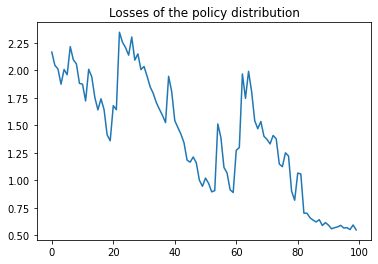

In [ ]:
plt.plot(final_losses_pi)
plt.title('Losses of the policy distribution')

Text(0.5, 1.0, 'Losses of the values estimations')

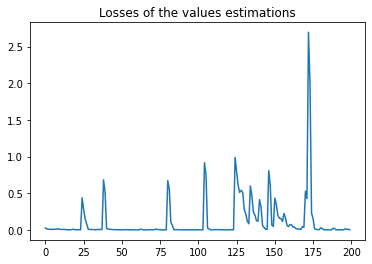

In [ ]:
plt.plot(final_losses_v)
plt.title('Losses of the values estimations')